## Genetic algorithm for FLP and LRP

This algorithm aims to utilize hybrid characteristics to solve the Facility location problem and its extention the location routing problem. The routing component is optional in the algorithm.

In [70]:
### Library import

import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import time

In [71]:
### Data import

filename = "instance654.txt"

with open(filename) as f:
    lines = f.readlines()
    NoCustomers = int(lines[0])
    X = []
    Y = []
    Dem = []
    for i in lines[1:]:
        X.append(float(i.split()[0]))
        Y.append(float(i.split()[1]))
        Dem.append(float(i.split()[2]))

        
Xcord = np.asarray(X).reshape(NoCustomers,1)
Ycord = np.asarray(Y).reshape(NoCustomers,1)
Demand = np.asarray(Dem).reshape(NoCustomers,1)


In [74]:
### Model parameters

NoFacil = 20
NoChromo = 60
NoCross = round(0.33*NoChromo)
NoMut = round(0.33*NoChromo)
NoRem = NoChromo-NoCross-NoMut
mutRate = 0.1 ##Mutation rate == How many chromosomes are mutated
numbMut = 2 ## Genes to be mutated in each mutated chromosome
NumberIter = 100


A1 = round(0.6*NoChromo)
A2 = round(0.3*NoChromo)
A3 = NoChromo-A1-A2


In [6]:
def get_Dist(X1,Y1,X2,Y2):
    return math.sqrt(math.pow(X1-X2,2)+math.pow(Y1-Y2,2))

In [7]:
def Facil_distance(Xcord,Ycord,ChromoX,ChromoY,NoCustomers):
    
    d = np.zeros((NoCustomers))
    for j in range(NoCustomers):
        d[j] = get_Dist(ChromoX,ChromoY,Xcord[j],Ycord[j])
    
    return d

In [8]:
def Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo):
    
    result =np.zeros((NoChromo))
    for i in range(NoChromo):
        d = np.zeros((NoCustomers,NoFacil))
        proximity = np.zeros((NoCustomers))
        
        for j in range(NoFacil):
            A =np.array((Xcord,Ycord))
            B = np.array((ChromoX[i,j],ChromoY[i,j]))
            A = np.reshape(A,(2,NoCustomers))
            B = np.reshape(B,(2,1))
            d[:,j]=np.linalg.norm((A-B),axis=0)
                
                #Facil_distance(Xcord,Ycord,ChromoX[i,j],ChromoY[i,j],NoCustomers)
        
        result[i]=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
        proximity=(d.argmin(axis=1))

    return result

In [9]:
def Weiszfeld(Xcord,Ycord,Xcenter,Ycenter,NoCustomers,Dem):
    
    improv = 1 
    epsilon = 10**(-2)
    itermax = 5
    
    Cost = (np.sum(np.multiply(Facil_distance(Xcord,Ycord,Xcenter,Ycenter,NoCustomers),Dem.T)))
    iterat = 0
    while ((improv>epsilon) and (iterat <itermax)):
        iterat=iterat+1
        x = 0
        y = 0
        W = 0
        d = np.zeros((NoCustomers))
        for j in range(NoCustomers):
            d[j] = get_Dist(Xcenter,Ycenter,Xcord[j],Ycord[j])
            if (d[j]!=0):
                w = (1/d[j])*(1/Dem[j])
                x = x+Xcord[j]*w
                y = y+Ycord[j]*w
                W = W +w
        
        if (W!=0):
            X = x/W
            Y = y/W
        else:
            X = x
            Y=y
        New_Cost = (np.sum(np.multiply(Facil_distance(Xcord,Ycord,X,Y,NoCustomers),Dem.T)))
        improv = Cost - New_Cost
        if (improv>epsilon):
            Cost = New_Cost
            Xcenter = X
            Ycenter = Y
    
    return Xcenter,Ycenter
    

In [10]:
def Cooper_Algorithm(Xcord,Ycord,ChromoX,ChromoY,NoCustomers,NoFacil,Dem):
    
    epsilon = 10**-2
    improvement = 1
    d = np.zeros((NoCustomers,NoFacil))
    proximity = np.zeros((NoCustomers))

    for i in range(NoFacil):
            A =np.array((Xcord,Ycord))
            B = np.array((ChromoX[i],ChromoY[i]))
            A = np.reshape(A,(2,NoCustomers))
            B = np.reshape(B,(2,1))
            d[:,i]=np.linalg.norm((A-B),axis=0)
                
        
    Cost=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
    proximity=(d.argmin(axis=1))
    
    tmpX = np.copy(ChromoX)
    tmpY = np.copy(ChromoY)


    while (improvement>epsilon):
        
        for j in range(NoFacil):
            #print(tmpX[j],tmpY[j])
            tmpX[j],tmpY[j] = Weiszfeld(Xcord[proximity==j],Ycord[proximity==j],tmpX[j],tmpY[j],sum(proximity==j),Dem[proximity==j])
            #print(tmpX[j],tmpY[j])
        
        d = np.zeros((NoCustomers,NoFacil))
        proximity = np.zeros((NoCustomers))
        for i in range(NoFacil):
            A =np.array((Xcord,Ycord))
            B = np.array((ChromoX[i],ChromoY[i]))
            A = np.reshape(A,(2,NoCustomers))
            B = np.reshape(B,(2,1))
            d[:,i]=np.linalg.norm((A-B),axis=0)
        
        New_Cost=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
        proximity=(d.argmin(axis=1))
        improvement = Cost - New_Cost
        Cost=New_Cost

    return Cost, tmpX,tmpY

In [11]:
def Cooper_Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo):
    
    
    
    z1 = np.zeros((NoChromo))
    tmpX = np.copy(ChromoX)
    tmpY = np.copy(ChromoY)
    
    t0 = time.time()
    for i in range(NoChromo):
        z1[i],tmpX[i],tmpY[i] = Cooper_Algorithm(Xcord,Ycord,ChromoX[i],ChromoY[i],NoCustomers,NoFacil,Demand)
        #if i % 10 ==0:
         #   print(i)
            
    t1 = time.time()  
    #print(t1-t0)
    return z1,tmpX,tmpY

In [12]:
def SimpleCrossover(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross):
    
    
    CrossX = np.zeros((NoCross,ChromoX.shape[1]))
    CrossY = np.zeros((NoCross,ChromoY.shape[1]))
    
    
    for i in range(NoCross):
        chromo1 = random.randint(0,NoChromo-1)                         ## First parent
        chromo2 = random.randint(0,NoChromo-1)                         ## Second parent
 
        cut = random.randint(0,NoFacil-1)                              ##Cut-off point

        CrossX[i,0:cut] = np.copy(ChromoX[chromo1,0:cut])
        CrossX[i,cut:] = np.copy(ChromoX[chromo2,cut:])
    
        CrossY[i,0:cut] = np.copy(ChromoY[chromo1,0:cut])
        CrossY[i,cut:] = np.copy(ChromoY[chromo2,cut:])
        
    return CrossX, CrossY

In [13]:
def SimpleMutation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoMut, mutRate, numbMut):
    
    
    mutX = np.zeros((NoMut,ChromoX.shape[1]))
    mutY = np.zeros((NoMut,ChromoY.shape[1]))

    
    for i in range(NoMut):
        chromo = random.randint(0,NoChromo-1)                         ## hromosome to be mutated
        mutX[i,:]=np.copy(ChromoX[chromo,:])
        mutY[i,:]=np.copy(ChromoY[chromo,:])
        
        genes = (random.sample(range(0, NoFacil-1), numbMut))
        for j in (genes):
            mutX[i,j] = np.random.rand()*(max(Xcord)-min(Xcord))
            mutY[i,j] = np.random.rand()*(max(Ycord)-min(Ycord))

    return mutX, mutY

In [14]:
def SimpleSurvival(ChromoX,ChromoY,fitness, NoRem):
    beta = 4    ## Hyperparameter

    RemX = np.zeros((NoRem,ChromoX.shape[1]))
    RemY = np.zeros((NoRem,ChromoY.shape[1]))
    CumFit = np.zeros((fitness.shape))
    
    Rev = np.exp(-(beta)*fitness/max(fitness))
    Tot = np.sum(Rev)
    indiv = Rev/Tot
    
    for i in range(len(fitness)):
        if i!=0:
            CumFit[i]=CumFit[i-1]+indiv[i]
        else:
            CumFit[i]=indiv[i]
            
            
    RemX[0,:] = np.copy(ChromoX[np.argmin(fitness)])
    RemY[0,:] = np.copy(ChromoY[np.argmin(fitness)])
    for j in range(1,NoRem):
        ind = np.random.rand()
        count = 0
        if ind<= CumFit[count]:
            RemX[j,:] = np.copy(ChromoX[count])
            RemY[j,:] = np.copy(ChromoY[count])
        else:
            while (ind>CumFit[count]):
                if (ind<=CumFit[count+1]):
                    RemX[j,:] = np.copy(ChromoX[count+1])
                    RemY[j,:] = np.copy(ChromoY[count])
                count = count+1
        
    
    return RemX,RemY       

In [15]:
def Initialization(Xcord, Ycord,Demand, NoChromo, NoFacil, NoCustomers, k1 , k2):
    
    epsilon = 10**(-5)
    Xmax = max(Xcord)
    Xmin = min(Xcord)
    Ymax = max(Ycord)
    Ymin = min(Ycord)
    
    Wx = (Xmax-Xmin)/k1
    Wy = (Ymax-Ymin)/k2
    

    Xgrid = np.zeros((k1+1))
    Ygrid = np.zeros((k2+1))
    
    tmpx = np.zeros((NoChromo,NoFacil))
    tmpy = np.zeros((NoChromo,NoFacil))
    

    Xgrid[0]=Xmin
    Ygrid[0]=Ymin
    for i in range(1,k1+1):
        Xgrid[i] = Xgrid[i-1]+Wx
    
    for i in range(1,k2+1):
        Ygrid[i]=Ygrid[i-1]+Wy
    
    
    BlockDem =np.zeros((k2,k1))
    BlockN = np.zeros((k2,k1))
    ProbGrid = np.zeros((k2,k1))
    
    for i in range(k1):
        for j in range(k2):
            for k in range(NoCustomers):
                if (Xcord[k]>=Xgrid[i]) and (Xcord[k]<Xgrid[i+1]+epsilon) and (Ycord[k]>=Ygrid[j]) and (Ycord[k]<Ygrid[j+1]+epsilon):
                    BlockDem[j,i] =BlockDem[j,i]+ Demand[k]
                    BlockN[j,i] = BlockN[j,i]+1
    
    for j in range(k2): 
        for i in range(k1):
            if (i==0) and (j==0):
                ProbGrid[j,i] = BlockN[j,i]     
            else:
                if (i==0):
                    ProbGrid[j,i] = BlockN[j,i] + ProbGrid[j-1,k1-1]

                else:
                    ProbGrid[j,i]=BlockN[j,i] + ProbGrid[j,i-1]

    
    ProbGrid = ProbGrid/np.sum(NoCustomers)
    

    
    
    
    for k in range(NoChromo):
        for n in range(NoFacil):
            r1 = np.random.rand(1)
            indX = np.zeros((1))
            indY = np.zeros((1))
            for j in range(k2): 
                for i in range(k1):
                    if i!=0:
                        if (r1<=ProbGrid[j,i] and r1 >ProbGrid[j,i-1]):
                            indX = i
                            indY = j 
            
                    else:
                        if (r1<=ProbGrid[j,i] and r1 >ProbGrid[j-1,k1-1]):
                            indX = i
                            indY = j 
           

            tmpx[k,n] = (Xgrid[int(indX)]+Xgrid[int(indX)+1])/2
            tmpy[k,n] = (Ygrid[int(indY)]+Ygrid[int(indY)+1])/2
            

    return tmpx,tmpy

In [43]:
tmX,tmY=Initialization(Xcord,Ycord,Demand,NoChromo,NoFacil,NoCustomers,25,25)
ChromoX = np.random.rand(NoChromo,NoFacil)*(max(Xcord)-min(Xcord))
ChromoY = np.random.rand(NoChromo,NoFacil)*(max(Ycord)-min(Ycord))

k1,_,_= Cooper_Evaluation(Xcord, Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)
k2,_,_= Cooper_Evaluation(Xcord, Ycord,Demand,tmX,tmY,NoCustomers,NoFacil,NoChromo)
print(np.mean(k1),np.mean(k2))

1638714.1099950536 1265094.754107932


In [16]:
def Grouping (fitness, A1,A2,A3,NoChromo):
    
    
    Group = np.zeros((NoChromo))
    
    temp = fitness.argsort()
    ranks = np.empty_like(temp)
    ranks[temp]=np.arange(len(fitness))
    
    
    for j in range(NoChromo):
        if ranks[j]<A1:
            Group[j]=0
        elif ranks[j]<A1+A2:
            Group[j] = 1
        else:
            Group[j] = 2
            
            
    return Group    

In [17]:
def NewSurvival(ChromoX,ChromoY,fitness, NoRem,A1,A2,A3,NoChromo,NoFacil):
    
    
    fit = np.copy(fitness)
    tmpx = np.copy(ChromoX)
    tmpy = np.copy(ChromoY)
    
    RemX = np.zeros((NoRem,NoFacil))
    RemY = np.zeros((NoRem,NoFacil))
    
    #print(fit)
    
    Groups = Grouping(fit,A1,A2,A3,NoChromo)
    Xbest = np.copy(ChromoX[np.argmin(fitness)])
    Ybest = np.copy(ChromoY[np.argmin(fitness)])

    
    for j in range(NoChromo-NoRem+1):
        Bad = np.sum(fit[Groups==2])
        Average = np.sum(fit[Groups==1])
        Good = np.sum(fit[Groups==0])
    
        Tot = Bad+Average+Good

    
        TH1 = Good/Tot
        TH2 = (Good+Average)/Tot
    
        Rem = np.random.rand()
        if (Rem<=TH1):
            k = 0
        elif(Rem<=TH2):
            k=1
        else:
            k=2
    
        options = np.array(np.where(Groups==k))
        options = options.reshape(options.shape[1],)
    
        index = np.random.choice(options,1)
        fit = np.delete(fit,index)
        Groups=np.delete(Groups,index)

        tmpx = np.delete(tmpx,index,axis=0)
        tmpy = np.delete(tmpy,index,axis=0)


    
    RemX[0:NoRem-1,:]=tmpx
    RemY[0:NoRem-1,:]=tmpy
    RemX[NoRem-1,:]=Xbest
    RemY[NoRem-1,:]=Ybest

    return RemX,RemY

In [18]:
def NewCrossover(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross,A1,A2,A3,fit):
     
    alpha =0.05
    k1=k2=10 
    Groups = Grouping(fit,A1,A2,A3,NoChromo)
    
    CrossX = np.zeros((NoCross,ChromoX.shape[1]))
    CrossY = np.zeros((NoCross,ChromoY.shape[1]))
    
    tmpx = np.copy(ChromoX)
    tmpy = np.copy(ChromoY)
    
    
    BusyN = np.zeros((NoChromo,NoFacil))
    BusyD = np.zeros((NoChromo,NoFacil))  
    Busy = np.zeros((NoChromo,NoFacil))
    

    proximity = np.zeros((NoCustomers))
    for j in range(NoChromo):
        d = np.zeros((NoCustomers,NoFacil))
        for i in range(NoFacil):
            A =np.array((Xcord,Ycord))
            B = np.array((ChromoX[j,i],ChromoY[j,i]))
            A = np.reshape(A,(2,NoCustomers))
            B = np.reshape(B,(2,1))
            d[:,i]=np.linalg.norm((A-B),axis=0)
            
        #Cost=(np.sum(np.multiply(d.min(axis = 1),Demand.T)))
        proximity=(d.argmin(axis=1))
       
        for i in range(NoFacil):
            BusyN[j,i]=np.count_nonzero(Demand[(proximity==i)])
            BusyD[j,i]=np.sum(Demand[proximity==i])
    
    
    Busy = np.sqrt(np.multiply(BusyN,BusyD))

    i = np.arange(len(Busy))[:, np.newaxis]
    j = np.argsort(Busy, axis=1)
    

    Busy = Busy[i,j]
    tmpx = tmpx[i,j]
    tmpy = tmpy[i,j]
       
    Xmax = max(Xcord)
    Xmin = min(Xcord)
    Ymax = max(Ycord)
    Ymin = min(Ycord)
    
    Wx = (Xmax-Xmin)/k1
    Wy = (Ymax-Ymin)/k2
    
 
    for i in range(NoCross):
        options = np.array(np.where(Groups==0))
        options = options.reshape(options.shape[1],)
        chromo1 = np.random.choice(options,1)                          ## First parent
                                                                               
        #tempoX =np.copy(ChromoX[chromo1,:])
        #tempoY = np.copy(ChromoY[chromo1,:])
        tempoX =np.copy(tmpx[chromo1,:])
        tempoY =np.copy(tmpy[chromo1,:])
        tempoX = np.flip(tempoX)
        tempoY = np.flip(tempoY)
        tempoX = tempoX.reshape(NoFacil,1)
        tempoY = tempoY.reshape(NoFacil,1)
        
             
        ## Step 3 cutoff point
        cut = random.randint(0,NoFacil-1)                              ##Cut-off point
         
  
        ## Step 4: Duplication    
        
        Dup =np.zeros((NoChromo))
        
        
        for z in range(NoChromo):
            
            if(z==chromo1):
                Dup[z]=10*NoFacil*NoFacil
                
            else:
                for j in range(0,cut):
                    for k in range(cut,NoFacil):
                        if ((abs(tempoX[j]-tmpx[z,k])<=alpha*Wx) and (abs(tempoY[j]-tmpy[z,k])<=alpha*Wy)):
                            Dup[z]=Dup[z]+1
                
                    
        chromo2=(np.argmin(Dup)) 
        
        
        ## Step 5 Assembly from the two
        
        
        CrossX[i,0:cut] = np.copy(tempoX[0:cut,0])
        CrossX[i,cut:] = np.copy(tmpx[chromo2,cut:])
    
        CrossY[i,0:cut] = np.copy(tempoY[0:cut,0])
        CrossY[i,cut:] = np.copy(tmpy[chromo2,cut:])

    return CrossX,CrossY
    

In [51]:
def NewMutation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoMut,fit):
    
    
    mutX = np.zeros((NoMut,ChromoX.shape[1]))
    mutY = np.zeros((NoMut,ChromoY.shape[1]))
    
    Groups = Grouping(fit,A1,A2,A3,NoChromo)
    
    tmpx = np.copy(ChromoX)
    tmpy = np.copy(ChromoY)
    
    
    BusyN = np.zeros((NoChromo,NoFacil))
    BusyD = np.zeros((NoChromo,NoFacil))  
    Busy = np.zeros((NoChromo,NoFacil))
    

    proximity = np.zeros((NoCustomers))
    for j in range(NoChromo):
        d = np.zeros((NoCustomers,NoFacil))
        for i in range(NoFacil):
            A =np.array((Xcord,Ycord))
            B = np.array((ChromoX[j,i],ChromoY[j,i]))
            A = np.reshape(A,(2,NoCustomers))
            B = np.reshape(B,(2,1))
            d[:,i]=np.linalg.norm((A-B),axis=0)

        proximity=(d.argmin(axis=1))
       
        for i in range(NoFacil):
            BusyN[j,i]=np.count_nonzero(Demand[(proximity==i)])
            BusyD[j,i]=np.sum(Demand[proximity==i])
    
    
    Busy = np.sqrt(np.multiply(BusyN,BusyD))
    
    Mu = np.zeros((NoChromo))
    Sigma = np.zeros((NoChromo))
    
    Mu = np.mean(Busy,axis=1)
    Sigma=np.std(Busy,axis=1)
    Emin = Mu-Sigma
    Emax = Mu+Sigma
    
    Change = np.zeros((NoChromo,NoFacil))
    
    Change[np.where(Busy>=Emax.reshape(NoChromo,1))]=1
    Change[np.where(Busy<=Emin.reshape(NoChromo,1))]=1
    
    for k in range(NoChromo):
        if (np.sum(Change[k,:])==NoFacil):
            Change[k,0]=0
            
    
    
    for k in range(NoMut):
        Changenew = np.copy(Change)
        options = np.array(np.where(Groups==0))
        options = options.reshape(options.shape[1],)
        chromo1 = np.random.choice(options,1)                          ## Chromo to be mutated
        
        mutX[k,:]=np.copy(tmpx[chromo1,:])
        mutY[k,:]=np.copy(tmpy[chromo1,:])
    
        d = np.zeros((NoCustomers,NoFacil))
    
        times = int(np.sum(Changenew[chromo1,:]))

        ##calculate initial distances with established facilities    
    
        for i in range(NoFacil):
            if (Changenew[chromo1,i]==0):
                A =np.array((Xcord,Ycord))
                B = np.array((mutX[k,i],mutY[k,i]))
                A = np.reshape(A,(2,NoCustomers))
                B = np.reshape(B,(2,1))
                d[:,i]=np.linalg.norm((A-B),axis=0)
    
    
    ## repeat for all times
        for i in range(times):
            #print("pass")
            k4=(Changenew[chromo1,:]==0)  
            k4 = k4.reshape(NoFacil,1)    
            d1=(d[:,np.where(k4)[0]])
            d2=np.min(d1,axis=1)
            d2=d2.reshape(NoCustomers,1)
            d3=np.argmax(d2)
        
            k5 =(Changenew[chromo1,:]==1)
            k5 = k5.reshape(NoFacil,1)
        
            mutX[k,np.where (k5)[0][0]]=Xcord[d3]
            mutY[k,np.where (k5)[0][0]]=Ycord[d3]

            Changenew[chromo1,np.where (k5)[0][0]]=0

            d = np.zeros((NoCustomers,NoFacil))
            for j in range(NoFacil):
                if (Changenew[chromo1,j]==0):
                    A =np.array((Xcord,Ycord))
                    B = np.array((mutX[k,j],mutY[k,j]))
                    A = np.reshape(A,(2,NoCustomers))
                    B = np.reshape(B,(2,1))
                    d[:,j]=np.linalg.norm((A-B),axis=0)
                    

    return  mutX, mutY

In [75]:
#ChromoX = np.random.rand(NoChromo,NoFacil)*(max(Xcord)-min(Xcord))
#ChromoY = np.random.rand(NoChromo,NoFacil)*(max(Ycord)-min(Ycord))

t0 = time.time()
ChromoX,ChromoY=Initialization(Xcord,Ycord,Demand,NoChromo,NoFacil,NoCustomers,25,25)

MinCost = np.zeros((NumberIter))

Fitness = np.zeros((NoChromo))


for it in range(NumberIter):
    
    print(100*it/NumberIter, " % ")
    
    ##Evaluation
    #Cost = Evaluation1(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)

    Fitness,ChromoX,ChromoY=Cooper_Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)
    
    #Fitness,_,_=Cooper_Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)
    MinCost[it]=(np.min(Fitness))
    print(MinCost[it])
    
    ##Crossover
    CrossX = np.zeros((NoCross,ChromoX.shape[1]))
    CrossY = np.zeros((NoCross,ChromoY.shape[1]))

    #CrossX,CrossY = SimpleCrossover(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross)
    CrossX,CrossY = NewCrossover(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross,A1,A2,A3,Fitness)
    
    ## Mutation
    mutX = np.zeros((NoMut,ChromoX.shape[1]))
    mutY = np.zeros((NoMut,ChromoY.shape[1]))

    #mutX,mutY =SimpleMutation(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoMut,mutRate,numbMut)
    mutX,mutY = NewMutation(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoMut,Fitness)
    
    ## Survival
    remX = np.zeros((NoRem,ChromoX.shape[1]))
    remY = np.zeros((NoRem,ChromoY.shape[1]))
    
    #remX,remY = SimpleSurvival(ChromoX,ChromoY,Fitness,NoRem)
    remX,remY = NewSurvival(ChromoX,ChromoY,Fitness,NoRem,A1,A2,A3,NoChromo,NoFacil)
    
    ##Population assembly
    ChromoX[0:NoCross,:] = np.copy(CrossX[:,:])
    ChromoX[NoCross:NoCross+NoMut,:]=np.copy(mutX[:,:])
    ChromoX[NoCross+NoMut:,:]=np.copy(remX[:,:])
    

    ChromoY[0:NoCross,:] = np.copy(CrossY[:,:])
    ChromoY[NoCross:NoCross+NoMut,:]=np.copy(mutY[:,:])
    ChromoY[NoCross+NoMut:,:]=np.copy(remY[:,:])



t1 = time.time()
print(t1-t0)

print(min(MinCost))



0.0  % 
114314.07665832335
1.0  % 
72068.10065946341
2.0  % 
66055.00394089258
3.0  % 
65652.13800645867
4.0  % 
65578.13562634258
5.0  % 
65577.84090293916
6.0  % 
65566.086759188
7.0  % 
65547.74831192679
8.0  % 
65547.64362420262
9.0  % 
65547.64362420262
10.0  % 
65547.64362420262
11.0  % 
65547.64362420262
12.0  % 
65547.64362420262
13.0  % 
65547.64362420262
14.0  % 
65547.64362420262
15.0  % 
65547.64362420262
16.0  % 
65547.64362420262
17.0  % 
65547.64362420262
18.0  % 
65547.64362420262
19.0  % 
65547.64362420262
20.0  % 
65547.64362420262
21.0  % 
65547.64362420262
22.0  % 
65547.64362420262
23.0  % 
65547.64362420262
24.0  % 
65547.64362420262
25.0  % 
65547.64362420262
26.0  % 
65547.64362420262
27.0  % 
65547.64362420262
28.0  % 
65547.64362420262
29.0  % 
65547.64362420262
30.0  % 
65547.64362420262
31.0  % 
65547.64362420262
32.0  % 
65547.64362420262
33.0  % 
65547.64362420262
34.0  % 
65547.64362420262
35.0  % 
65547.64362420262
36.0  % 
65547.64362420262
37.0  % 
655

[114314.07665832  72068.10065946  66055.00394089  65652.13800646
  65578.13562634  65577.84090294  65566.08675919  65547.74831193
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   65547.6436242   65547.6436242
  65547.6436242   65547.6436242   6554

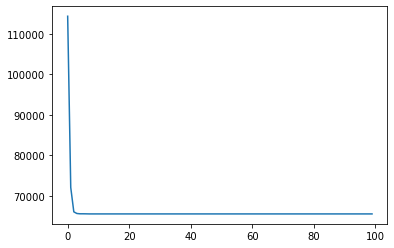

In [76]:
print(MinCost)
plt.plot(MinCost)